TODO: rename `get_filtered_df` -> `get freq df`

In [834]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [835]:
%matplotlib inline

In [836]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lmfit.models import GaussianModel

import time

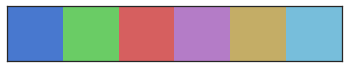

In [837]:
import seaborn as sns
sns.set_style("white")
pal = sns.color_palette('muted')
sns.palplot(pal)

In [838]:
plt.rcParams.update({
    'figure.autolayout': False,
    'figure.figsize'   : (15,9),
    'font.size'        : 20,         # default font size (to match the above figsize)
    'font.family'      : 'serif',    # avoid sns warning
    'axes.titlesize'   : 'medium',
    'axes.labelsize'   : 'medium',
    'ytick.labelsize'  : 'small',  # font size relative to the default
    'xtick.labelsize'  : 'small',
    'legend.fontsize'  : 'small'
})

In [839]:
from utils import load_google_counts, get_filtered_df

A word is considered alive when it is used more than 0.05 * median(word). `resilience_thres = 0.05`

In [840]:
import numba

@numba.jit(nopython=True)
def word_new_resilience(word, median, thres):
    res, res_max = 0, 0
    end_max = 0
    N = word.shape[0]
    for idx in range(N):
        if word[idx] > thres * median:  # is really alive
            res += 1
        elif res <= res_max:
            res = 0
        else:
            res_max = res
            end_max = idx - 1
            res = 0
    if res > res_max:
        res_max, end_max = res, N - 1
                  # ----- start -----
    return res_max, end_max-res_max+1, end_max

@numba.jit(nopython=True)
def _res_wrapper(mat, medians, thres):
    N = mat.shape[1]                           # number of words
    result = np.empty((3, N), dtype=np.uint16) # at most 208 years => uint8
    for i in range(N):
        result[:, i] = word_new_resilience(mat[:, i], medians[i], thres)
    return result

def df_new_resilience(df, thres=0.05):
    medians = np.median(df.values, axis=0)      # take the median over the life time. 10x faster than pandas
    result  = _res_wrapper(df.values, medians, thres)
    res_df  = pd.DataFrame(result.T, columns=['res', 'start', 'end'], index=df.columns)
    res_df[['start', 'end']] += df.index[0]
    return res_df


### Load params for current session

In [872]:
N = 1
lang = 'eng'
start_year = 1800
end_year = 2012

resilience_thres = 0.1
kernel_resilience = 200
kernel_start = time.time()

In [855]:
def get_title(title):
    return '{t} ({l}, {n}-grams)'.format(t=title, l=lang, n=N)

In [873]:
dict_counts = load_google_counts(lang, N, start_year, end_year)
len(dict_counts.keys())

267489

In [874]:
counts = pd.DataFrame(dict_counts)
counts.index += start_year
# remove 2009 -> 2012
counts = counts.loc[:2008]

In [875]:
freqs, word_ranks = get_filtered_df(counts)
# freqs = counts # use counts for new resilience

Got 267489 words
Filtered down to 267489 words


In [876]:
ress = df_new_resilience(freqs, resilience_thres)

In [847]:
res = ress.res
count_gby_res = counts.groupby(lambda word_lbl: res[word_lbl] - res[word_lbl] % 50 + 50, axis='columns')
sizes_by_res  = count_gby_res.apply(lambda group_df: group_df.sum(axis='columns'))

In [848]:
# sanity checks
for gname, group_df in count_gby_res:
    r = df_new_resilience(freqs.loc[:, group_df.columns], resilience_thres)
    print(r.res.min(), r.res.max())

2 49
50 99
100 149
150 199
200 209


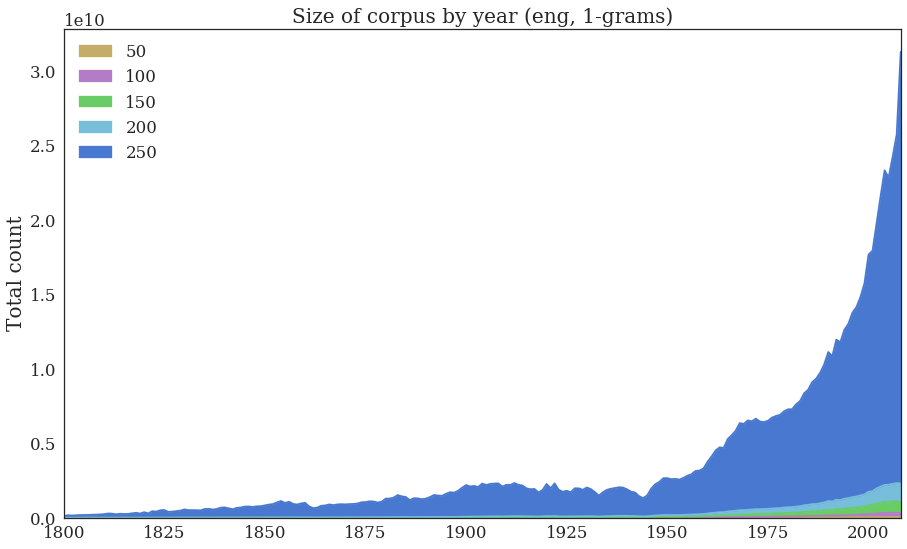

In [849]:
sns.set_palette([pal[4], pal[3], pal[1], pal[5], pal[0], pal[2]])
sizes_by_res.plot.area(title=get_title('Size of corpus by year'))
plt.ylabel('Total count')
if N == 1:
    plt.savefig('figures/{l}-{n}-size-res2.jpg'.format(l=lang, n=N))
sns.set_palette(pal)

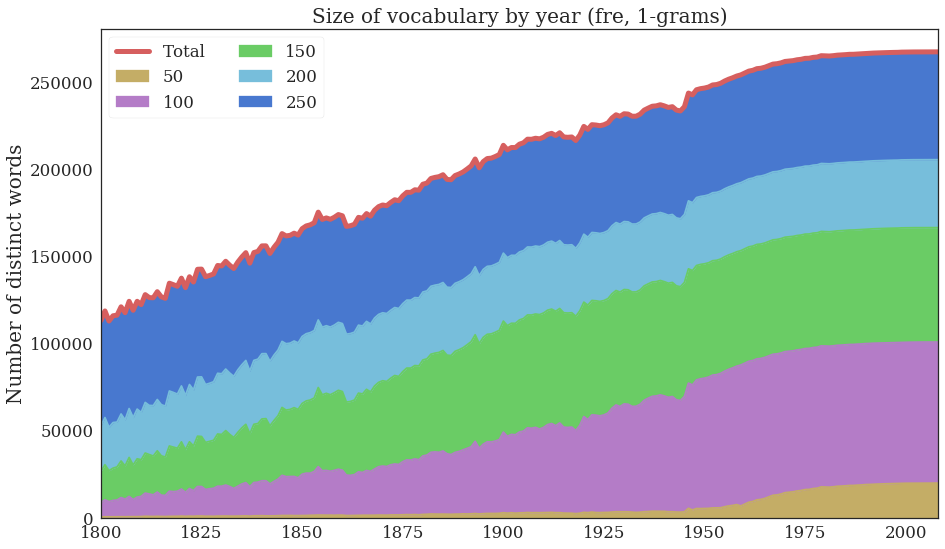

In [860]:
sns.set_palette([pal[4], pal[3], pal[1], pal[5], pal[0], pal[2]])
vocab_res = count_gby_res.apply(lambda group_df: (group_df > 0).sum(axis='columns'))
vocab_res.plot.area(title=get_title('Size of vocabulary by year'), label='Total')

_total_vocab = vocab_res.sum(axis='columns')
_total_vocab.name = 'Total'
_total_vocab.plot(linewidth=5)

plt.ylabel('Number of distinct words')
plt.legend(ncol=2, frameon=True)

plt.savefig('figures/{l}-{n}-vocab-res2.jpg'.format(l=lang, n=N))
sns.set_palette(pal)

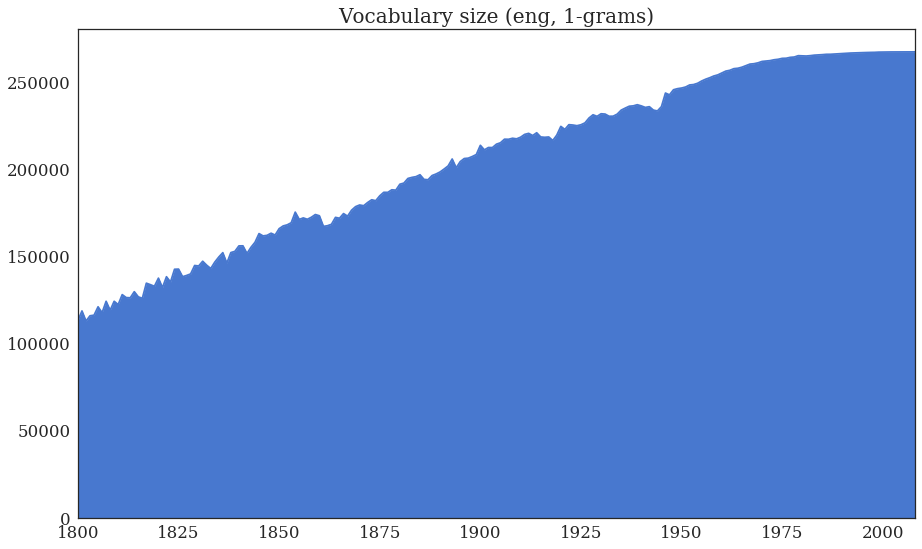

In [853]:
_total_vocab.plot.area(title=get_title('Vocabulary size'))

Number of words per resilience

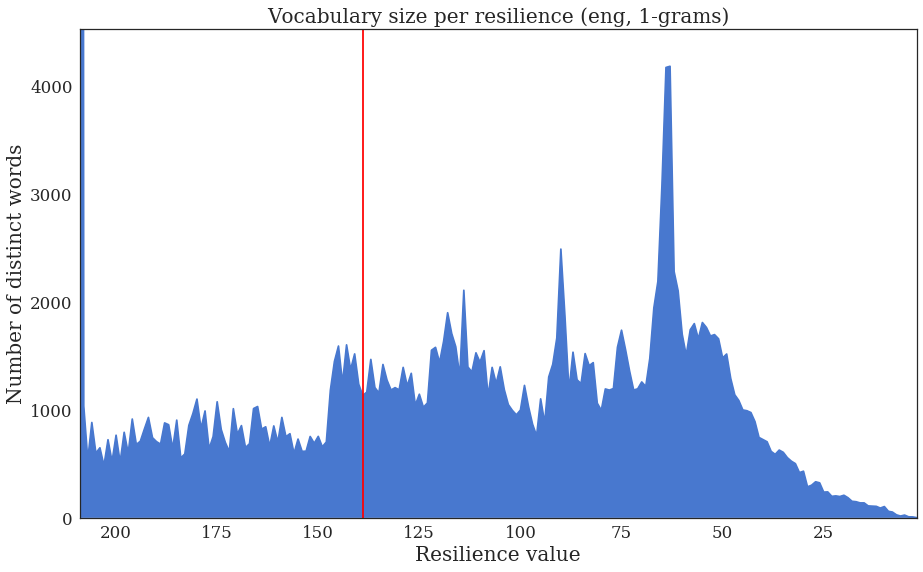

In [877]:
words_per_res = ress.res.value_counts(sort=False).sort_index(ascending=False)
words_per_res.plot.area(figsize=(15, 9), ylim=(0, words_per_res[5:].max() + 350), title=get_title('Vocabulary size per resilience'))
plt.axvline(x=139, ymin=0, ymax=1500, color='red')
plt.xlabel('Resilience value')
plt.ylabel('Number of distinct words')
# plt.savefig('figures/{l}-{n}-var-res.jpg'.format(l=lang, n=N))

In [878]:
ress_complete = ress.loc[(ress.start > 1800) & (ress.end < 2008)]

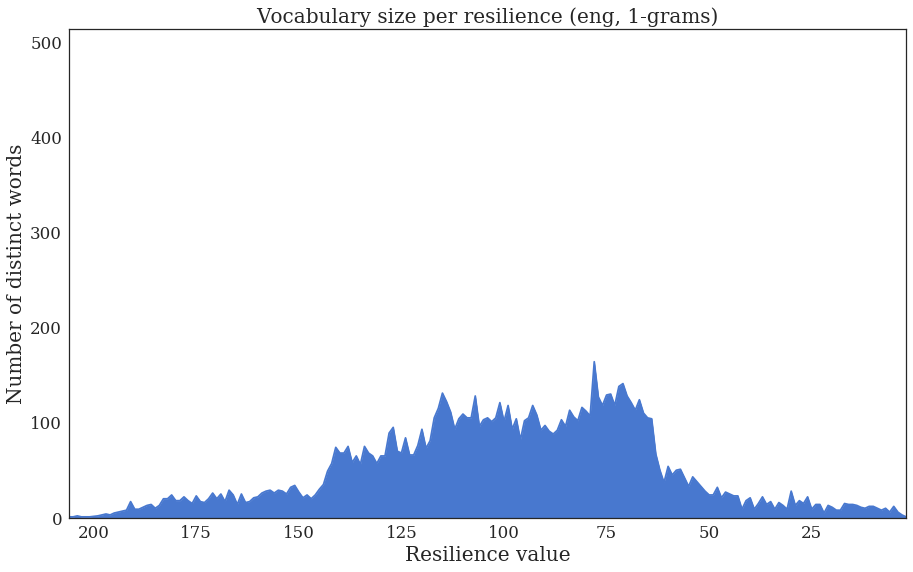

In [879]:
words_per_res = ress_complete.res.value_counts(sort=False).sort_index(ascending=False)
words_per_res.plot.area(ylim=(0, words_per_res[5:].max() + 350), title=get_title('Vocabulary size per resilience'))
# plt.axvline(x=139, ymin=0, ymax=1500, color='red')
plt.xlabel('Resilience value')
plt.ylabel('Number of distinct words')
# plt.savefig('figures/{l}-{n}-var-res.jpg'.format(l=lang, n=N))

In [822]:
for r in [64, 75, 90, 137, 139]:
    counts.loc[:, (ress.res == r)].sum().sort_values(ascending=False).to_csv('fre-1-spectrum-{r}.csv'.format(r=r))

In [803]:
ress.loc[ress.res == 75].index.to_series().to_csv('./out_files/fre-1-spectrum-75.csv')

In [861]:
vocab = vocab_res.sum(axis='columns')

In [862]:
birth_count = ress.start.value_counts(sort=False).sort_index()
death_count = ress.end.value_counts(sort=False).sort_index()

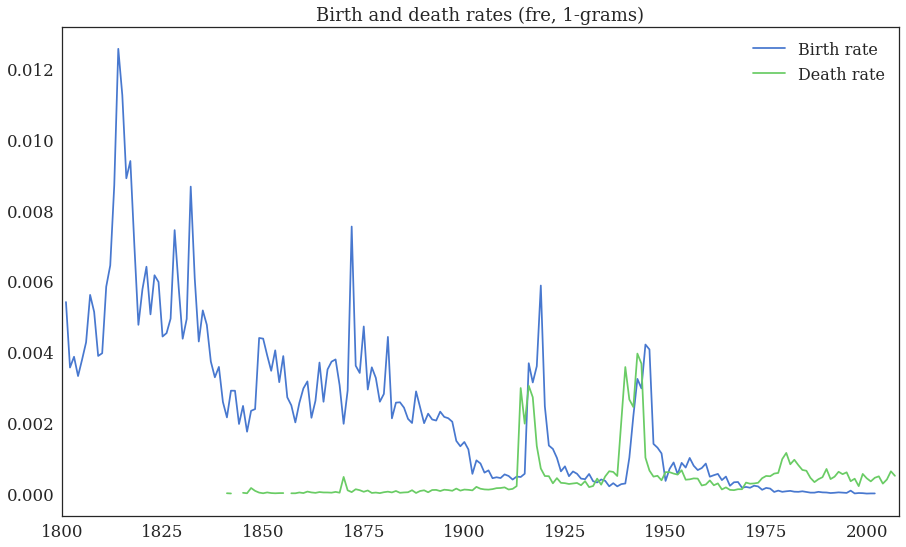

In [864]:
plt.figure(figsize=(15, 9))
birth_rate = (birth_count / vocab)[1:] # skip the first one where all are new
death_rate = (death_count / vocab)[:-1]
birth_rate.plot()
death_rate.plot()
plt.title('Birth and death rates ({l}, {n}-grams)'.format(l=lang, n=N), fontsize=18)
plt.legend(['Birth rate', 'Death rate'], fontsize=16)
# plt.yscale('log')

# plt.savefig('figures/{l}-{n}-rates.jpg'.format(l=lang, n=N))

In [697]:
path = './out_files/{}-{}-words-{}.csv'
ress[ress.start == 1850].to_csv(path.format(lang, N, 1850))
ress[ress.start == 1950].to_csv(path.format(lang, N, 1950))

In [698]:
time.time() - kernel_start

8.398446798324585

In [699]:
print(lang, N)

ger 4


path = './out_files/{}-{}-deaths-{}.csv'
for lang in {'eng', 'fre', 'spa', 'ger'}:
    for n in range(1, 6):
        dict_counts = load_google_counts(lang, n, 1800, 2012)
        counts = pd.DataFrame(dict_counts)
        counts.index += 1800
        counts = counts.loc[:2008]
        freqs, _words_ranks = get_filtered_df(counts)
        ress = df_new_resilience(freqs, resilience_thres)
        ress[ress.end == 1850].to_csv(path.format(lang, n, 1850))
        ress[ress.end == 1950].to_csv(path.format(lang, n, 1950))

def avg_use(births, freqs):
    s = 0
    starts = births.start - 1800
    ends   = births.end   - 1800
    for word_lbl, word_freq in freqs[births.index].items():
        s += np.median(word_freq.values[ starts[word_lbl] : ends[word_lbl] ])
    return s / births.shape[0]

rgb = ress.loc[ress.start > 1800].groupby('start')

piercing_freqs = rgb.apply(avg_use, freqs)

if 0: w.columns[w.columns.str.len() >20]

if 0: # old stuff
    print('Before', dnk.shape)
    dnk = dnk.loc[:, df_resilience(dnk) < 50]
    print('After', dnk.shape)

    def find_fit(word, x, model):
        # find fitting curve
        y = word.values
        params = model.guess(y, x)
        fitted = model.fit(y, params, x=x)
        return fitted
    #     ideal = fitted.eval(x=x)

        # get distance (cosine)
    #     d = ideal.inner(word) / (np.sqrt(ideal.inner(ideal)) * np.sqrt(word.inner(word)))

    #     return ideal

    from scipy.optimize import curve_fit

    def gaussian(x, amp, cen, wid):
        return amp * np.exp(-(x-cen)**2 / wid)

    def find_fit_scipy(word, x):
        y = word.values
        mean = sum(x * y)
        sigma = sum(y * (x-mean)**2)
        popt, pcov = curve_fit(gaussian, x, y, p0=(1, mean, sigma))
        return popt

    x = dnk.index.values
    m = GaussianModel()
    dnk.apply(find_fit, axis='rows', args=(x, m))

    %%timeit dt = dnk.iloc[:, np.random.randint(0, dnk.shape[1], 50)]
    dt.apply(find_fit, axis='rows', args=(x,m))

    %%timeit dt.apply(find_fit, axis='rows', args=(x,m))

    m = GaussianModel()

    dnk.absender.plot()

    x = dnk.index.values

    %timeit r1 = find_fit(dnk.absender, x, m)

    r2 = find_fit_scipy(dnk.absender, x)



    r2 = curve_fit(gaussian, x, dnk.absender.values * 10**5, p0=[0,1941,23])[0]

    r2

    r1 = find_fit(dnk.absender, x, m)

    dnk.absender.plot()
    plt.plot(x, gaussian(x, r2[0]* 1e-5, r2[1], r2[2]))
    # plt.plot(x, r1.best_fit)

    m.guess(dnk.absender.values, x=x)

    r2.best_values

    dnk.absender.plot()
    plt.plot(x, r2.best_fit)

    w.zemstwo.plot()

    res.loc['zemstwo']